<a href="https://colab.research.google.com/github/cibelerusso/MRASII/blob/main/C%C3%B3digos%20em%20Python/SME0823_Regulariza%C3%A7%C3%A3o_em_modelos_lineares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SME0823 Modelos de Regressão e Aprendizado Supervisionado II


#  Regularização em modelos de regressão lineares - Exemplo



por **Cibele Russo**

**ICMC/USP - São Carlos SP**




**Referências:**

- Draper, N. R., & Smith, H. (1998). Applied regression analysis. 3rd edition. Wiley.

- James, Gareth et al. (2023) An introduction to statistical learning. New York: Springer. Disponível em https://link.springer.com/book/10.1007/978-3-031-38747-0

- Dobson, A. J.; Barnett, Adrian G. (2018). An introduction to generalized linear models. CRC press.

# Modelos de regressão

**Objetivos**

Predizer $Y$ a partir do conhecimento de variáveis em $X = x$.


Em notação matricial, um modelo linear geral é dado por

$$\large{Y = f(X,\beta)+\epsilon,}$$

em que

- Y é a **variável resposta** (vetor de variáveis aleatórias observáveis),

- X contém **variáveis preditoras** ou **explicativas** (matriz conhecida, ou seja, não-aleatória),

- $\beta$ é um **vetor de parâmetros de interesse**, desconhecidos e que queremos estimar,

- $f$ é uma função das variáveis preditoras e dos parâmetros de interesse,

- $\epsilon$ é o **erro aleatório** (vetor de erros aleatórios não observáveis).




## Aplicação


Suponha que desejamos predizer o valor de venda de uma casa utilizando variáveis preditoras como número de quartos, número de banheiros, tamanho da sala, número de andares, entre outras.

Fonte e alguns desenvolvimentos adicionais: ver https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices

In [58]:
### Atenção: pode ser necessário atualizar os pacotes numpy e scikit-learn pip install --upgrade numpy scikit-learn

#!pip install --upgrade numpy scikit-learn

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

import folium
from folium.plugins import HeatMap

warnings.filterwarnings('ignore')

avaliacao = pd.DataFrame({'Modelo': [],
                           'Detalhes': [],
                           'Erro Quadrático Médio (RMSE)': [],
                           'R-quadrado (treinamento)': [],
                           'R-quadrado ajustado (treinamento)': [],
                           'R-quadrado (teste)': [],
                           'R-quadrado ajustado (teste)': [],
                           'Validação Cruzada 5-Fold': []})


df = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/IntroducaoaInferenciaEstatistica/main/Dados/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [60]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [61]:
df.rename(columns={
    'id': 'id',
    'date': 'data',
    'price': 'preco',
    'bedrooms': 'quartos',
    'bathrooms': 'banheiros',
    'sqft_living': 'area_util',
    'sqft_lot': 'area_total',
    'floors': 'andares',
    'waterfront': 'frente_para_agua',
    'view': 'vista',
    'condition': 'condicao',
    'grade': 'classificacao',
    'sqft_above': 'area_sobre_o_nivel_do_chao',
    'sqft_basement': 'area_porao',
    'yr_built': 'ano_construcao',
    'yr_renovated': 'ano_reforma',
    'zipcode': 'cep',
    'lat': 'latitude',
    'long': 'longitude',
    'sqft_living15': 'area_util_vizinhanca',
    'sqft_lot15': 'area_total_vizinhanca'
}, inplace=True)


In [62]:
df.describe()

,id,preco,quartos,banheiros,area_util,area_total,andares,frente_para_agua,vista,condicao,classificacao,area_sobre_o_nivel_do_chao,area_porao,ano_construcao,ano_reforma,cep,latitude,longitude,area_util_vizinhanca,area_total_vizinhanca
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21611.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.396095,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.128162,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Text(0.5, 1.0, 'Matriz de correlações de Pearson')

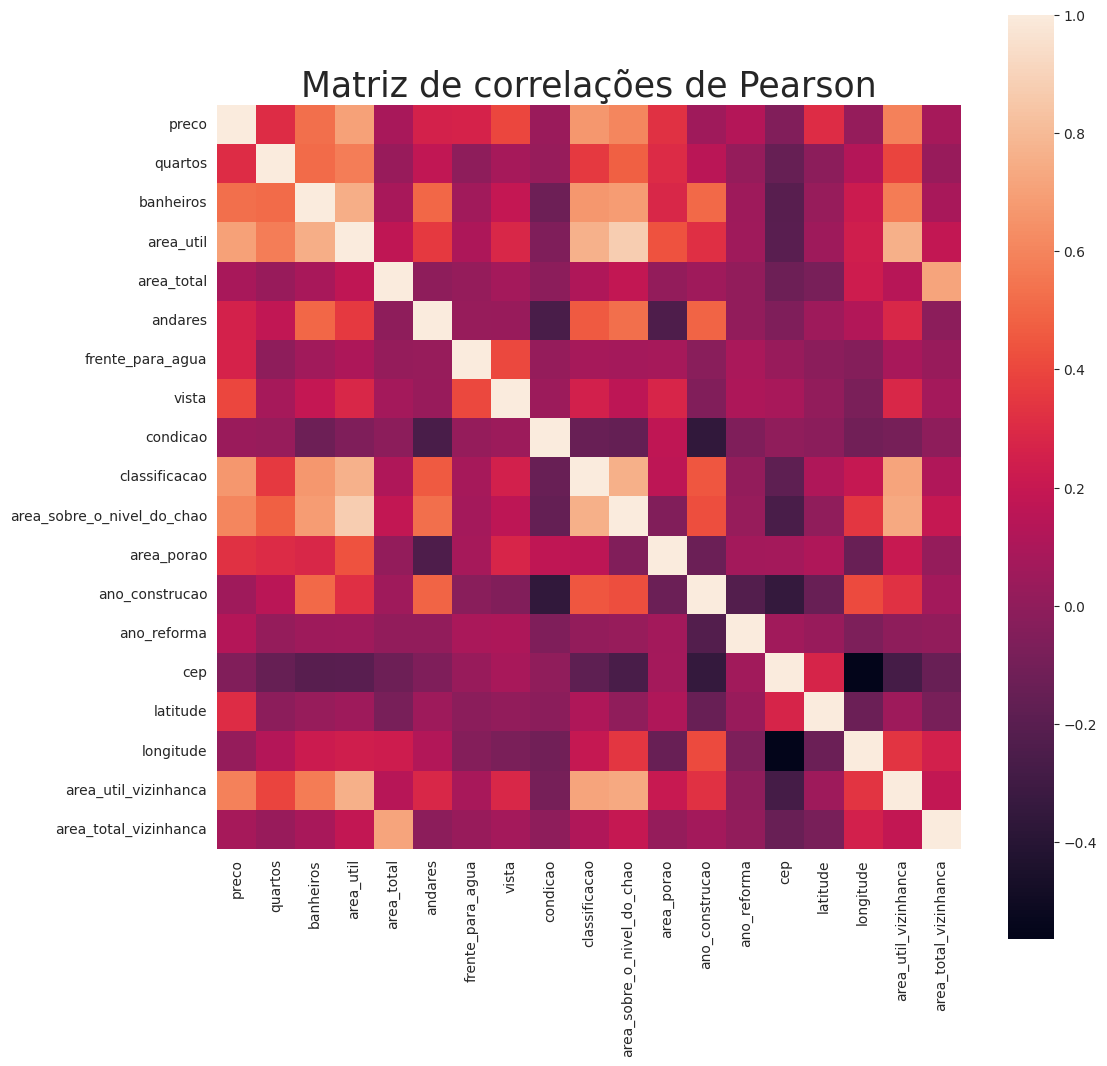

In [63]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.drop(['id', 'data'], axis=1).corr(), square=True)

plt.title('Matriz de correlações de Pearson',fontsize=25)



## Modelo linear simples

In [64]:
from statsmodels.formula.api import ols

#Ajusta o modelo de regressão linear simples para o preço das casas
mod = ols("preco~area_util",data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  preco   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.100e+04
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:42:00   Log-Likelihood:            -3.0027e+05
No. Observations:               21613   AIC:                         6.005e+05
Df Residuals:                   21611   BIC:                         6.006e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.358e+04   4402.690     -9.899      0.0

**Modelo ajustado**

$\hat{Y}_i = -43580 + 280.62 \text{ area\_util}$

## Modelo linear múltiplo

In [65]:
X = df[['quartos', 'banheiros', 'area_util', 'area_total', 'andares',
        'frente_para_agua', 'vista', 'condicao', 'classificacao']].values

y = df['preco'].values

In [66]:
from statsmodels.formula.api import ols

# Ajusta o modelo de regressão linear múltipla para o preço das casas
modelo = ols('preco ~ quartos + banheiros + area_util + area_total + andares + frente_para_agua + vista + condicao + classificacao', data=df)

res = modelo.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  preco   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     3673.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:42:00   Log-Likelihood:            -2.9757e+05
No. Observations:               21613   AIC:                         5.952e+05
Df Residuals:                   21603   BIC:                         5.952e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6.827e+05   1.73e+04  

## Análise de resíduos (ordinários)

In [67]:
# Ajusta o modelo de regressão linear múltipla para o preço das casas com duas preditoras
modelo = ols('preco ~ quartos + banheiros + area_util + area_total + andares + frente_para_agua + vista + condicao + classificacao', data=df)
res = modelo.fit()

# Valores ajustados de E(Y)
ypred = res.fittedvalues

# Resíduo = observado - ajustado
residuo = res.resid


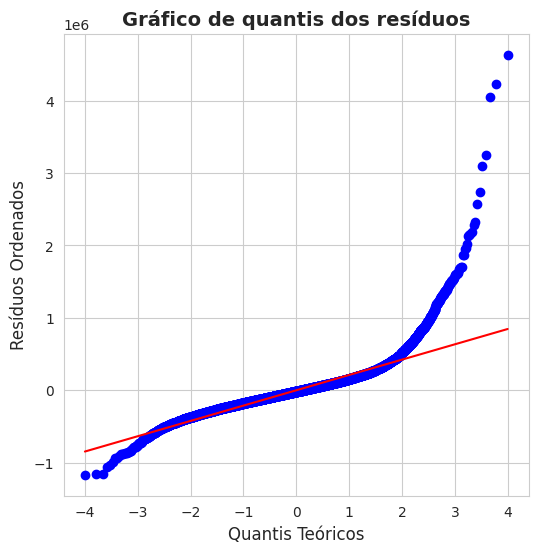

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Estilização do gráfico
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")

# Criando o Q-Q plot
stats.probplot(residuo, plot=plt)

# Melhorando rótulos e título
plt.xlabel("Quantis Teóricos", fontsize=12)
plt.ylabel("Resíduos Ordenados", fontsize=12)
plt.title("Gráfico de quantis dos resíduos", fontsize=14, fontweight="bold")

# Exibindo o gráfico
plt.show()


## Transformação em Y

Transformação de Box Cox: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

In [69]:
stats.boxcox(df['preco'])

(array([4.03347724, 4.07834415, 4.0214467 , ..., 4.06460704, 4.0643512 ,
        4.05395394]),
 np.float64(-0.23401843658425156))

In [70]:
df['preco_transformado'] = (pow(df['preco'],-0.234) - 1)/(-0.234)

In [71]:
X = df[['quartos', 'banheiros', 'area_util', 'area_total', 'andares',
        'frente_para_agua', 'vista', 'condicao', 'classificacao']]

Y = df['preco_transformado']

## Número de modelos possíveis com todas as combinações de variáveis

In [72]:
2 ** 9

512

## Exercício

Utilize o método Forward para selecionar variáveis para este modelo com a resposta transformada


In [73]:
# Stepwise (Forward Selection)
# Usando PE = PS = 0.15, conforme sugerido em Paula (2025).
print("\n Procedimento Stepwise (Forward Selection) ")
import numpy as np
import statsmodels.api as sm

def stepwise_forward(X_data, Y_data, entry_p_value=0.15):
    remaining = list(X_data.columns)
    selected = []

    print(f"\nProcedimento Stepwise (Forward Selection)")
    print(f"PE (Nível de Inclusão) = {entry_p_value}")

    while True:
        best_p_value = np.inf
        best_feature = None

        # Tenta adicionar a melhor variável restante
        for feature in remaining:
            current_subset = selected + [feature]
            X_current = sm.add_constant(X_data[current_subset], prepend=True)

            # Requisito: deve haver mais observações do que parâmetros
            n, p = X_current.shape
            if p >= n:
                continue

            model = sm.OLS(Y_data, X_current).fit()

            # P-valor da variável que acabou de ser adicionada
            if feature in model.pvalues.index:
                p_value = model.pvalues[feature]
            else:
                continue

            if p_value < best_p_value:
                best_p_value = p_value
                best_feature = feature

        # Critério de Parada/Inclusão (Pmin <= PE)
        if best_feature and best_p_value < entry_p_value:
            selected.append(best_feature)
            remaining.remove(best_feature)
            print(f"PASS: Adiciona '{best_feature}' (P-valor: {best_p_value:.4f}). "
                  f"Modelo atual: {' + '.join(['1'] + selected)}")
        else:
            break

    # Ajusta o modelo final
    if selected:
        print("\nModelo Final Selecionado pelo Stepwise")
        X_final = sm.add_constant(X_data[selected], prepend=True)
        final_model = sm.OLS(Y_data, X_final).fit()
        print(final_model.summary())
        return final_model
    else:
        print("Nenhuma variável foi selecionada.")
        return None


stepwise_forward(X, Y, entry_p_value=0.15)


 Procedimento Stepwise (Forward Selection) 

Procedimento Stepwise (Forward Selection)
PE (Nível de Inclusão) = 0.15
PASS: Adiciona 'quartos' (P-valor: 0.0000). Modelo atual: 1 + quartos
PASS: Adiciona 'banheiros' (P-valor: 0.0000). Modelo atual: 1 + quartos + banheiros
PASS: Adiciona 'area_util' (P-valor: 0.0000). Modelo atual: 1 + quartos + banheiros + area_util
PASS: Adiciona 'classificacao' (P-valor: 0.0000). Modelo atual: 1 + quartos + banheiros + area_util + classificacao
PASS: Adiciona 'condicao' (P-valor: 0.0000). Modelo atual: 1 + quartos + banheiros + area_util + classificacao + condicao
PASS: Adiciona 'vista' (P-valor: 0.0000). Modelo atual: 1 + quartos + banheiros + area_util + classificacao + condicao + vista
PASS: Adiciona 'frente_para_agua' (P-valor: 0.0000). Modelo atual: 1 + quartos + banheiros + area_util + classificacao + condicao + vista + frente_para_agua
PASS: Adiciona 'andares' (P-valor: 0.0000). Modelo atual: 1 + quartos + banheiros + area_util + classificacao 

In [74]:

# Ajusta o modelo de regressão linear múltipla para o preço das casas com duas preditoras
modelo = ols('preco_transformado ~ quartos + banheiros + area_util + classificacao + condicao + vista + frente_para_agua + andares + area_total', data=df)
res = modelo.fit()

# Valores preditos de E(Y)
ypred = res.fittedvalues

# Resíduo = observado - ajustado
residuo = res.resid


In [75]:
ax.scatter(ypred, residuo)
ax.set_ylabel('$y-\hat{y}$')
ax.set_title('Resíduos')


Text(0.5, 1.0, 'Resíduos')

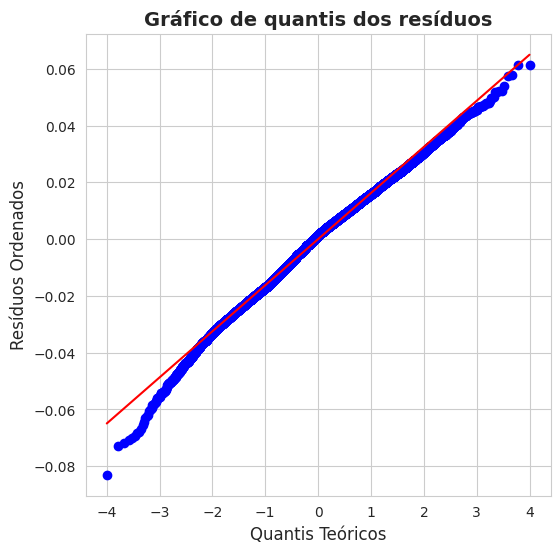

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Estilização do gráfico
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")

# Criando o Q-Q plot
stats.probplot(residuo, plot=plt)

# Melhorando rótulos e título
plt.xlabel("Quantis Teóricos", fontsize=12)
plt.ylabel("Resíduos Ordenados", fontsize=12)
plt.title("Gráfico de quantis dos resíduos", fontsize=14, fontweight="bold")

# Exibindo o gráfico
plt.show()


In [77]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/IntroducaoaInferenciaEstatistica/main/Dados/kc_house_data.csv')
df.head()

df.rename(columns={
    'id': 'id',
    'date': 'data',
    'price': 'preco',
    'bedrooms': 'quartos',
    'bathrooms': 'banheiros',
    'sqft_living': 'area_util',
    'sqft_lot': 'area_total',
    'floors': 'andares',
    'waterfront': 'frente_para_agua',
    'view': 'vista',
    'condition': 'condicao',
    'grade': 'classificacao',
    'sqft_above': 'area_sobre_o_nivel_do_chao',
    'sqft_basement': 'area_porao',
    'yr_built': 'ano_construcao',
    'yr_renovated': 'ano_reforma',
    'zipcode': 'cep',
    'lat': 'latitude',
    'long': 'longitude',
    'sqft_living15': 'area_util_vizinhanca',
    'sqft_lot15': 'area_total_vizinhanca'
}, inplace=True)

df['preco_transformado'] = (pow(df['preco'],-0.234) - 1)/(-0.234)


## Métricas com bases de treinamento e teste

In [78]:
df = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/IntroducaoaInferenciaEstatistica/main/Dados/kc_house_data.csv')
df.head()

df.rename(columns={
    'id': 'id',
    'date': 'data',
    'price': 'preco',
    'bedrooms': 'quartos',
    'bathrooms': 'banheiros',
    'sqft_living': 'area_util',
    'sqft_lot': 'area_total',
    'floors': 'andares',
    'waterfront': 'frente_para_agua',
    'view': 'vista',
    'condition': 'condicao',
    'grade': 'classificacao',
    'sqft_above': 'area_sobre_o_nivel_do_chao',
    'sqft_basement': 'area_porao',
    'yr_built': 'ano_construcao',
    'yr_renovated': 'ano_reforma',
    'zipcode': 'cep',
    'lat': 'latitude',
    'long': 'longitude',
    'sqft_living15': 'area_util_vizinhanca',
    'sqft_lot15': 'area_total_vizinhanca'
}, inplace=True)

df['preco_transformado'] = (pow(df['preco'],-0.234) - 1)/(-0.234)

df = df.dropna()

# Definição das covariáveis
X = df[['quartos', 'banheiros', 'area_util', 'area_total', 'andares', 'frente_para_agua', 'vista', 'condicao',
       'classificacao', 'area_sobre_o_nivel_do_chao', 'area_porao', 'ano_construcao', 'ano_reforma', 'cep']]
y = df['preco_transformado']

# Definição das covariáveis
X = df[['quartos', 'banheiros', 'area_util', 'area_total', 'andares', 'frente_para_agua', 'vista', 'condicao',
       'classificacao', 'area_sobre_o_nivel_do_chao', 'area_porao', 'ano_construcao', 'ano_reforma', 'cep']]
y = df['preco_transformado']

In [79]:
# Ajusta o modelo de regressão linear múltipla para o preço das casas com duas preditoras
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

# Divisão treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=1)

train_data, test_data = train_test_split(df, test_size=0.8, random_state=1)

modelo = ols('preco_transformado ~ area_util + classificacao', data=train_data)
res = modelo.fit()

In [80]:
previsao = res.predict(X_teste)

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(previsao, y_teste)

0.013653819338127636

In [82]:
mse = mean_squared_error(previsao, y_teste)

mse

0.00028432486696373206

## Regularização em Modelos de Regressão

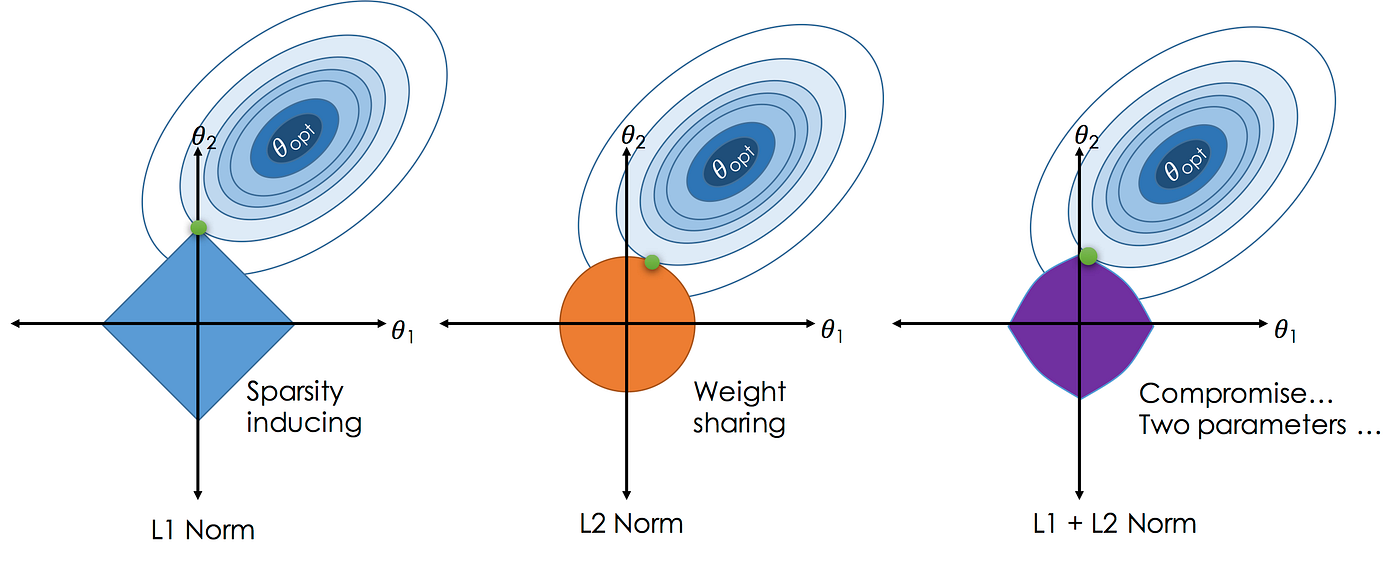

Fonte: https://pet-estatistica.github.io/site/download/posts/postALTAMIRO.html



A **regularização** é uma técnica utilizada para lidar com os problemas de sobreajuste (overfitting) e subajuste (underfitting) em modelos de aprendizado de máquina.

O sobreajuste ocorre quando um modelo apresenta alta variância, ajustando-se excessivamente aos dados de treinamento, o que pode prejudicar seu desempenho em novos dados.

Isso geralmente acontece quando o modelo é muito complexo, contendo muitas curvas e variações desnecessárias. Por outro lado, o subajuste ocorre quando o modelo é muito simples e não captura adequadamente os padrões dos dados, resultando em um desempenho insatisfatório.


Duas formas muito utilizadas de regularização são a **Regressão Ridge (Rígida)** e o **Lasso**.

### Quando Utilizar Ridge ou Lasso

- Se há muitos efeitos pequenos ou médios nas variáveis preditoras, recomenda-se o uso da Regressão Ridge.
- Se apenas algumas variáveis possuem um efeito médio ou grande, recomenda-se o uso do Lasso.

**Regressão Ridge**


A regressão Ridge, também conhecida como regularização **L2**, adiciona um termo de penalização à função de custo da regressão linear, conforme a equação abaixo:

$$
RSS_{\text{Ridge}} = \sum_{i=1}^{m} (h_{\theta}(x_i) - y_i)^2 + \alpha \sum_{j=1}^{n} \theta_j^2
$$

O parâmetro $\alpha$ controla a intensidade da regularização. Quando $\alpha$ aumenta, a penalização sobre os coeficientes também aumenta, reduzindo sua magnitude e simplificando o modelo. Quando $\alpha$ diminui, a regularização tem um impacto menor, permitindo que os coeficientes assumam valores mais elevados.



**Lasso**


A regressão Lasso, ou regularização **L1**, também adiciona um termo de penalização à função de custo, mas de forma diferente da regressão Ridge. A equação da regressão Lasso é:

$$
RSS_{\text{Lasso}} = \sum_{i=1}^{m} (h_{\theta}(x_i) - y_i)^2 + \alpha \sum_{j=1}^{n} |\theta_j|
$$

A principal característica do Lasso é a capacidade de forçar alguns coeficientes $\theta_j$ a se tornarem exatamente zero, o que efetivamente realiza uma seleção de variáveis. Isso torna o Lasso particularmente útil quando se acredita que apenas um subconjunto pequeno das variáveis explicativas tem um efeito significativo no modelo.

Assim como na regressão Ridge, o parâmetro $\alpha$ controla a intensidade da regularização. Valores maiores de $\alpha$ aumentam a penalização, reduzindo o número de variáveis efetivamente utilizadas no modelo.

O Lasso é uma escolha poderosa quando se deseja obter modelos mais interpretáveis, eliminando automaticamente variáveis irrelevantes e simplificando a estrutura do modelo.



In [83]:

df = pd.read_csv('https://raw.githubusercontent.com/cibelerusso/IntroducaoaInferenciaEstatistica/main/Dados/kc_house_data.csv')
df.head()

df.rename(columns={
    'id': 'id',
    'date': 'data',
    'price': 'preco',
    'bedrooms': 'quartos',
    'bathrooms': 'banheiros',
    'sqft_living': 'area_util',
    'sqft_lot': 'area_total',
    'floors': 'andares',
    'waterfront': 'frente_para_agua',
    'view': 'vista',
    'condition': 'condicao',
    'grade': 'classificacao',
    'sqft_above': 'area_sobre_o_nivel_do_chao',
    'sqft_basement': 'area_porao',
    'yr_built': 'ano_construcao',
    'yr_renovated': 'ano_reforma',
    'zipcode': 'cep',
    'lat': 'latitude',
    'long': 'longitude',
    'sqft_living15': 'area_util_vizinhanca',
    'sqft_lot15': 'area_total_vizinhanca'
}, inplace=True)

df['preco_transformado'] = (pow(df['preco'],-0.234) - 1)/(-0.234)


In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

df = df.dropna()

# Definição das covariáveis
X = df[['quartos', 'banheiros', 'area_util', 'area_total', 'andares', 'frente_para_agua', 'vista', 'condicao',
       'classificacao', 'area_sobre_o_nivel_do_chao', 'area_porao', 'ano_construcao', 'ano_reforma', 'cep']]
y = df['preco_transformado']

# Divisão treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=1)

# Regressão Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_treino, y_treino)
y_pred_ridge = ridge.predict(X_teste)
mse_ridge = mean_squared_error(y_teste, y_pred_ridge)
print(f'MSE Ridge: {mse_ridge:.4f}')

# Regressão Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_treino, y_treino)
y_pred_lasso = lasso.predict(X_teste)
mse_lasso = mean_squared_error(y_teste, y_pred_lasso)
print(f'MSE Lasso: {mse_lasso:.4f}')


MSE Ridge: 0.0002
MSE Lasso: 0.0003


In [85]:
import pandas as pd

# Criando um DataFrame para comparar os coeficientes
coef_df = pd.DataFrame({
    'Variável': X_treino.columns,
    'Coef_Ridge': ridge.coef_,
    'Coef_Lasso': lasso.coef_
})

print(coef_df)


                      Variável    Coef_Ridge    Coef_Lasso
0                      quartos -6.175783e-04 -0.000000e+00
1                    banheiros  3.390274e-03  0.000000e+00
2                    area_util  5.106736e-06  1.784643e-05
3                   area_total  3.422672e-09 -7.835330e-09
4                      andares  5.083646e-03  0.000000e+00
5             frente_para_agua  1.130222e-02  0.000000e+00
6                        vista  1.824203e-03  0.000000e+00
7                     condicao  2.297803e-03  0.000000e+00
8                classificacao  1.053637e-02  0.000000e+00
9   area_sobre_o_nivel_do_chao  1.040769e-06  0.000000e+00
10                  area_porao  4.066052e-06  0.000000e+00
11              ano_construcao -2.278595e-04 -0.000000e+00
12                 ano_reforma  5.487628e-07  3.586174e-06
13                         cep  1.080166e-05  6.878789e-06
